In [52]:
'''Import standard data sceince libraries'''
import os # used for file handling
from matplotlib import pyplot as plt # used for plotting graphs
import numpy as np # used for numerical computing

'''Import image processing libraries'''
from PIL import Image # used for image processing

'''Import Torch Libraries'''
import torch # Pytorch
import torchvision.datasets as datasets # Import the datasets from torchvision for training and testing
import torchvision.transforms as transforms # used for transforming image
import torch.nn as nn # Pytorch Neural Network class
import torch.optim as optim # Pytorch Optimizer
from torchsummary import summary # used to get the model summary

In [36]:
'''Set manual seed for the torch randomly generated parameters to have same values'''
torch.manual_seed(42) # So that weights are always initialized to some particular random value

In [37]:
'''Check if CPU or GPU is available'''
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set the device to GPU is available else CPU

In [30]:
'''Create a folder for saved models if it doesn't exist'''
if not os.path.exists('model'): # if the folder doesn't exist
    os.makedirs('model') # create the folder

In [31]:
'''
Specify transforms using torchvision.transforms as transforms
# One of the methods of normalizing the data from the world of statistics is (x - x.mean()) / x.std()) (F-score)
'''

train_transformations = transforms.Compose([ # Compose is used to chain multiple transformations together
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # Normalize the image
]) # The mean and standard deviation values are the values for the CIFAR-10 dataset

test_transformations = transforms.Compose([ # Compose is used to chain multiple transformations together
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # Normalize the image
]) # The mean and standard deviation values are the values for the CIFAR-10 dataset

In [35]:
'''----------------- prepare training data -----------------------'''
train_set = datasets.CIFAR10(
    root='./data.cifar10',                          # location of the dataset
    train=True,                                     # this is training data
    transform=train_transformations,                # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W)
    download=True                                   # if you haven't had the dataset, this will automatically download it for you
) # CIFAR-10 dataset (60,000 32x32 colour images in 10 classes, with 6,000 images per class

'''----------------- prepare testing data -----------------------'''
test_set = datasets.CIFAR10(
    root='./data.cifar10/',                         # location of the dataset
    train=False,                                    # this is testing data
    transform=test_transformations,                 # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W)
) # CIFAR-10 dataset (60,000 32x32 colour images in 10 classes, with 6,000 images per class

# Print the classes in the train set and length of test set
print(f"Classes in data:\n{train_set.classes}\n\nLength of Test Set: {len(test_set)}")

Files already downloaded and verified
Classes in data:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Length of Test Set: 10000


In [ ]:
'''Load datasets into Dataloader using torch library'''
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True) # Load the training data
test_loader = torch.utils.data.DataLoader(test_set, batch_size =64,shuffle=False) # Load the testing data

In [39]:
'''Check if the mini batch is being loaded everytime we call train loader'''
for l in range(2):
    img,lab = next(iter(train_loader))
    print(img.size(),lab.size())

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [45]:
'''----------------- build the model ------------------------'''
class SwapNet(nn.Module):
    def __init__(self):
        super(SwapNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512) # 3*32*32 = 3072 (flattened image)
        self.fc2 = nn.Linear(512, 256) # 512 input features, 256 output features
        self.fc3 = nn.Linear(256, 10) # 256 input features, 10 output features (for 10 classes)
        self.drop = nn.Dropout(0.2) # Dropout layer with 20% probability
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the CIFAR-10 image (3x32x32 -> 3072)
        
        # First fully connected layer + ReLU + dropout
        x = self.fc1(x) # Fully connected
        x = self.relu(x) # ReLU
        x = self.drop(x) # Dropout
        
        # Second fully connected layer + ReLU + dropout
        x = self.fc2(x) # Fully connected
        x = self.relu(x) # ReLU
        x = self.drop(x) # Dropout
        
        # Output layer (logits for 10 classes; no activation here because CrossEntropyLoss applies softmax internally)
        x = self.fc3(x) # Fully connected
        return x

In [47]:
'''
Model Summary: Tells you how you built the model:
    * the number of parameters in the model
    * the weights in every convolutional layer that need to get trained in the fully connected layers
    * tells use that there are 6.58 million weights that need to be trained when we train the model
'''
model = SwapNet().to(device) # Create an instance of the model and send it to the device
summary(model, input_size=(3, 32, 32)) # Print the model summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 6.51
Estimated Total Size (MB): 6.54
----------------------------------------------------------------


In [48]:
n_epoch = 30 # Number of epochs
lr = 0.001 # Learning rate
optimizer = optim.Adam(model.parameters(),lr = lr) # Adam optimizer is used
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss is used for multi-class classification as a loss function   

In [ ]:
'''Containers for storing data'''

train_correct = 0 # Number of correct predictions in training set
train_samples = 0 # Number of samples in training set
test_correct = 0 # Number of correct predictions in testing set
test_samples = 0 # Number of samples in testing set

train_losses = [] # List to store training losses
test_losses = [] # List to store testing losses

In [ ]:
'''Train-Test Loop'''

for epoch in range(n_epoch): # Loop through the number of epochs
    model.train() # Set the model to training mode
    for idx,data in enumerate(train_loader): # Loop through the training data
        X,y = data # Get the features and labels from the data
        
        optimizer.zero_grad() # Zero the gradients
        y_pred = model(X) # Get the predictions
        
        loss = loss_fn(y_pred.float(),y) # Calculate the loss

        _, predicted = torch.max(y_pred, 1) # Get the predicted class
        
        # Update the running total of correct predictions and samples
        train_correct += (predicted == y).sum().item() # Get the number of correct predictions
        train_samples += y.size(0) # Get the number of samples
        
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update the weights

    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # No need to calculate gradients
        for data in test_loader: # Loop through the testing data
            images,labels=data[0],data[1] # Get the features and labels
            
            outputs=model(images) # Get the predictions
            
            test_loss= loss_fn(outputs.float(),labels) # Calculate the loss
            
            _, predicted = outputs.max(1) # Get the predicted class
            test_samples+= labels.size(0) # Get the number of samples
            test_correct += predicted.eq(labels).sum().item() # Get the number of correct predictions
        
        
    # Display metrics
    train_losses.append(loss.item()) # Append the training loss
    test_losses.append(test_loss.item()) # Append the test loss
    train_accuracy = 100 * train_correct / train_samples # Calculate the training accuracy
    test_accuracy = 100 * test_correct / test_samples # Calculate the test accuracy
    print(f"Epoch:{epoch} Train Loss:{loss.item()} Accuracy: {train_accuracy:.2f}% Test Loss: {test_loss.item()} TestAccuracy: {test_accuracy:.2f}%") # Print the metrics

Epoch:0 Train Loss:1.4152134656906128 Accuracy: 37.76% Test Loss: 1.5495151281356812 TestAccuracy: 43.42%
Epoch:1 Train Loss:1.6318811178207397 Accuracy: 40.43% Test Loss: 1.66453218460083 TestAccuracy: 44.65%
Epoch:2 Train Loss:1.8203985691070557 Accuracy: 42.04% Test Loss: 1.4564577341079712 TestAccuracy: 45.66%
Epoch:3 Train Loss:0.7136831879615784 Accuracy: 43.18% Test Loss: 1.324305772781372 TestAccuracy: 46.41%
Epoch:4 Train Loss:0.9193024635314941 Accuracy: 44.18% Test Loss: 1.3764280080795288 TestAccuracy: 47.11%
Epoch:5 Train Loss:1.549744725227356 Accuracy: 45.08% Test Loss: 1.690565586090088 TestAccuracy: 47.35%
Epoch:6 Train Loss:1.6578853130340576 Accuracy: 45.85% Test Loss: 1.4165393114089966 TestAccuracy: 47.79%
Epoch:7 Train Loss:2.2408101558685303 Accuracy: 46.57% Test Loss: 1.4295449256896973 TestAccuracy: 48.16%
Epoch:8 Train Loss:1.9459586143493652 Accuracy: 47.21% Test Loss: 1.6822524070739746 TestAccuracy: 48.41%
Epoch:9 Train Loss:0.9974238872528076 Accuracy: 47.

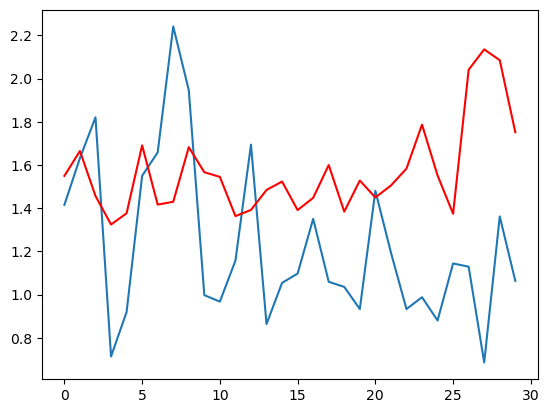

In [53]:
'''Loss curve plotting'''

ep = [] # Store number of epochs
for i in range(n_epoch):
    ep.append(i)
    
plt.plot(ep,train_losses)
plt.plot(ep,test_losses,c='r')
plt.show()